In [18]:
# Import the dataset
from sklearn.datasets import fetch_olivetti_faces

X_train = fetch_olivetti_faces().data
target = fetch_olivetti_faces().target

[]

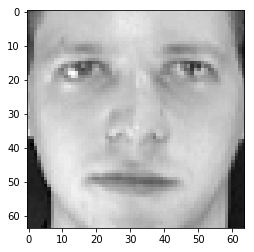

In [19]:
# Show an image
import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape(64, 64), cmap = plt.cm.gray)
plt.plot()

In [20]:
# Put labels to one hot vectors
from keras.utils import to_categorical

y_train = to_categorical(target)
y_train.shape

(400, 40)

In [32]:
# define the encoder
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.layers.merge import concatenate as concat

n_pixels = 4096
n_z = 2
n_classes = y_train.shape[1]
batch_size = 10

decoder_dim = 512
encoder_dim = 512

# define the input layer: the pixel values
input_img = Input(shape=(n_pixels,))

# encode
encoder_h = Dense(encoder_dim, activation='relu', name='encoder')(input_img)

# compute the mu and sigma
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='sigma')(encoder_h)

def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# compute z
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with labels
label = Input(shape=(n_classes,))
zc = concat([z, label])

# decode
decoder_hidden = Dense(decoder_dim, activation='relu', name='decoder')
decoder_output = Dense(n_pixels, activation='sigmoid', name='output')
decoder = decoder_hidden(zc)
outputs = decoder_output(decoder)

In [33]:
# Define the custom loss
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [34]:
# define the CVAE
cvae = Model([input_img, label], outputs)

# the encoder
encoder = Model([input_img, label], mu)

# the decoder
d_in = Input(shape=(n_z+n_classes,))
d_h = decoder_hidden(d_in)
d_out = decoder_output(d_h)
decoder = Model(d_in, d_out)

In [35]:
# Compile
cvae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])

In [36]:
# fit
from keras.callbacks import EarlyStopping

cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=batch_size, epochs=50)

Epoch 1/50
400/400 [==============================] - 3s 7ms/step - loss: 2756.0282 - KL_loss: 12.0272 - recon_loss: 2744.0010
Epoch 2/50
 30/400 [=>............................] - ETA: 2s - loss: 2729.4521 - KL_loss: 3.3591 - recon_loss: 2726.0929

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,KL_loss,recon_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


400/400 [==============================] - 2s 5ms/step - loss: 2716.1128 - KL_loss: 4.2570 - recon_loss: 2711.8558
Epoch 3/50
400/400 [==============================] - 2s 5ms/step - loss: 2703.3750 - KL_loss: 4.6090 - recon_loss: 2698.7660
Epoch 4/50
400/400 [==============================] - 2s 5ms/step - loss: 2682.3567 - KL_loss: 4.4961 - recon_loss: 2677.8607
Epoch 5/50
400/400 [==============================] - 2s 5ms/step - loss: 2664.0598 - KL_loss: 4.5182 - recon_loss: 2659.5416
Epoch 6/50
400/400 [==============================] - 2s 6ms/step - loss: 2652.6385 - KL_loss: 4.5209 - recon_loss: 2648.1176
Epoch 7/50
400/400 [==============================] - 3s 7ms/step - loss: 2645.0390 - KL_loss: 4.7084 - recon_loss: 2640.3306
Epoch 8/50
400/400 [==============================] - 3s 6ms/step - loss: 2639.5483 - KL_loss: 4.4227 - recon_loss: 2635.1256
Epoch 9/50
400/400 [==============================] - 3s 6ms/step - loss: 2635.2488 - KL_loss: 4.4483 - recon_loss: 2630.8006
Epo

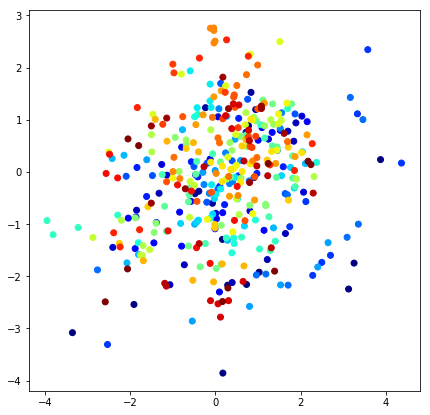

In [41]:
# Compute the encoding mean values and visualize them
mu_train = encoder.predict([X_train, y_train])

plt.figure(figsize=(7, 7))
plt.scatter(mu_train[:, 0], mu_train[:, 1], c=target, cmap=plt.cm.jet)
plt.show()

In [43]:
# Just a simple function to transform a encoded latent space and class value to a one hot vector
import numpy as np
def build_vector(digit, z = None):
    out = np.zeros((1, n_z + n_classes))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
vector_3 = build_vector(3)
print(vector_3)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


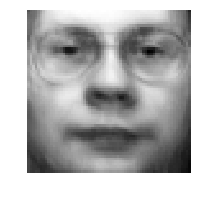

In [45]:
# Show a example of 3 with latent values to zeros
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(vector_3).reshape(64,64), cmap = plt.cm.gray)
plt.axis('off')
plt.show()

In [51]:
# Now we can look at the impact of the latent variables on the aspect of the digit
def display_variables(digit, grid_side=8):
    min_z = np.min(mu_train[np.where(target==digit)])
    max_z = np.max(mu_train[np.where(target==digit)])

    count = 1

    plt.figure(figsize=(12, 12))

    for i in range(grid_side):
        for j in range(grid_side):
            # Compute z1 and z2 all over the ranges
            z1 = min_z + i/(grid_side-1)*(max_z-min_z)
            z2 = min_z + j/(grid_side-1)*(max_z-min_z)
            # Compute the input vector
            input_vector = build_vector(digit, [z1, z2])
            # Compute the decoder prediction
            decoded_im = decoder.predict(input_vector)
            # Plot the decoded predicted image
            plt.subplot(grid_side, grid_side, count)
            plt.imshow(decoded_im.reshape(64, 64), cmap = plt.cm.gray)

            # Increment the counter for viz
            count +=1
            plt.axis('off')

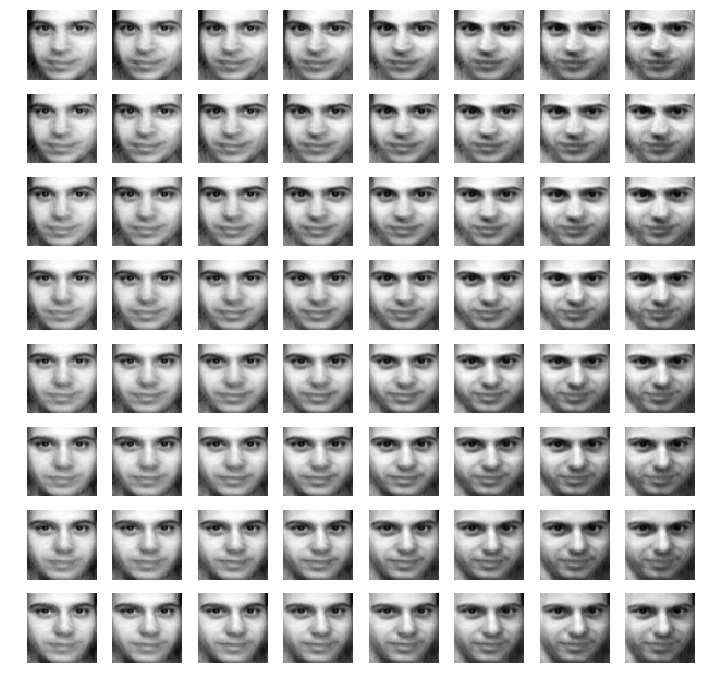

In [56]:
display_variables(8, 8)

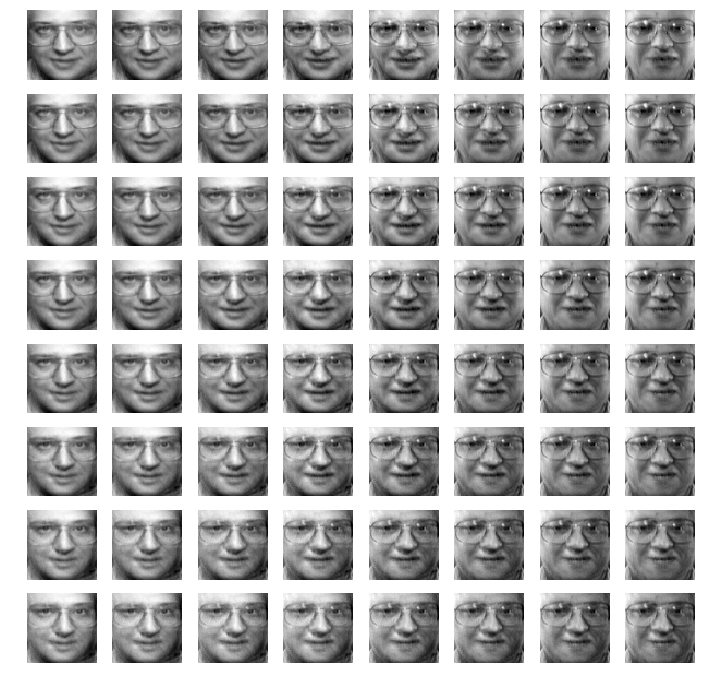

In [57]:
display_variables(30, 8)

The latent variables control the orientation of the face